# Load Dependencies


In [119]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch

# import pyciemss
# from pyciemss.PetriNetODE.interfaces import setup_model, reset_model, intervene, sample, calibrate, optimize, load_petri_model
# import mira
from pyciemss.PetriNetODE.interfaces import setup_model, intervene, sample, calibrate, optimize
from pyciemss.utils import get_tspan
from pyciemss.utils import setup_ax, plot_predictive, plot_trajectory, plot_intervention_line, plot_ouu_risk

from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.ouu import computeRisk, solveOUU
from pyciemss.risk.qoi import scenario2dec_sample_average
import numpy as np
import time

import warnings
warnings.filterwarnings('ignore')

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup parameters


In [190]:
full_tspan = torch.tensor([float(x) for x in list(range(1,90))])

# Total population, N.
N = 100000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0., 81.0, 0., 0. #may want to revisit this choice, consider setting I0 to 1 (there will not be zero recovered people when there are 81 infectious people)
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

# 18 - 24 year olds
I_obs_data = [81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31] #these numbers make no sense, why not use whole numbers?
plot_I_obs = dict(I_obs=torch.tensor(I_obs_data))
I_obs = [(float(i+1), dict(I_obs=obs/N)) for i, obs in enumerate(I_obs_data)]
observed_tspan = torch.tensor([float(x) for x in list(range(1,len(I_obs)+1))])

# named_initial_state = {
#     "S": torch.as_tensor(S0),
#     "V": torch.as_tensor(V0),
#     "I": torch.as_tensor(I0),
#     "I_v": torch.as_tensor(Iv0),
#     "R": torch.as_tensor(R0),
# }

# named_final_state = {
#     "S": torch.as_tensor(S0),
#     "V": torch.as_tensor(V0),
#     "I": I_obs[-1],
#     "I_v": torch.as_tensor(Iv0),
#     "R": torch.as_tensor(R0),
# }

# Probabilistic forecasting - ignoring any observed data

### Load the model

In [187]:
from pyciemss.PetriNetODE.models import MIRA_I_obs_with_scaled_Gaussian_noise
model_json = '../../test/models/SVIIvR_mira.json'
petri_net_ode_model = MIRA_I_obs_with_scaled_Gaussian_noise.from_mira(model_json)
petri_net_ode_model.total_population = N
petri_net_ode_model.data_reliability = 4.0
petri_net_ode_model

MIRA_I_obs_with_scaled_Gaussian_noise(
	beta = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),
	betaV = Uniform(low: 0.03375000134110451, high: 0.04125000163912773),
	nu = Uniform(low: 0.0044999998062849045, high: 0.005499999970197678),
	gamma = Uniform(low: 0.1574999988079071, high: 0.19249999523162842),
	gammaV = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	total_population = 100000.0,
	data_reliability = 4.0
)

### Initialize model

In [189]:
initialized_petri_net_ode_model = setup_model(petri_net_ode_model, start_time=0.0, start_state=dict(S=S0, V=V0, I=I0, I_v=Iv0, R=R0))

## Q: "What likely future outcomes does our model imply while ignoring observed Data?"

### Sample a single trajectory from the prior distribution

In [173]:
single_prior = sample(initialized_petri_net_ode_model, timepoints=full_tspan, num_samples=1)
single_prior['I_obs'] = single_prior['I_sol'] + single_prior['I_v_sol']

### Sample 100 trajectories from the prior distribution

In [178]:
prior_prediction = sample(initialized_petri_net_ode_model, timepoints=full_tspan, num_samples=100)
prior_prediction['I_obs'] = prior_prediction['I_sol'] + prior_prediction['I_v_sol']

### Plot trajectories using prior information only

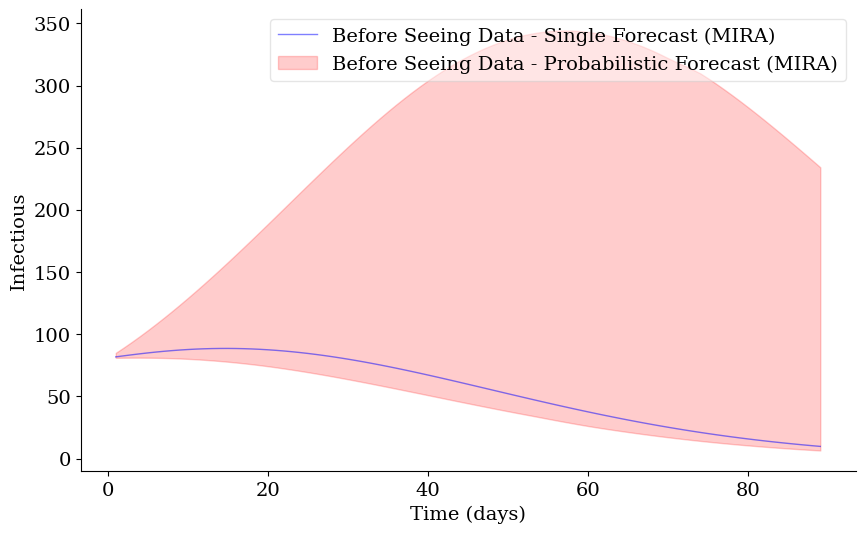

In [180]:
ax = plot_trajectory(single_prior, full_tspan, color="blue", label="Before Seeing Data - Single Forecast (MIRA)", marker='', lw=1.)
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast (MIRA)", color="red", alpha=0.2)

## Probabibilistic forecasting - incorporating observed data

### Calibration

In [8]:
data = [(float(i+1), dict(I_obs=obs)) for i, obs in enumerate([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])]
calibrated_parameters = calibrate(initialized_petri_net_ode_model, data=data, verbose=True)

iteration 0: loss = 27.183197736740112
iteration 25: loss = 23.785506010055542
iteration 50: loss = 19.826377630233765
iteration 75: loss = 17.44716715812683
iteration 100: loss = 17.64667820930481
iteration 125: loss = 17.483870267868042
iteration 150: loss = 17.9587459564209
iteration 175: loss = 17.811434507369995
iteration 200: loss = 16.015715837478638
iteration 225: loss = 17.33594584465027
iteration 250: loss = 16.64981198310852
iteration 275: loss = 18.193193674087524
iteration 300: loss = 15.041191816329956
iteration 325: loss = 16.066094160079956
iteration 350: loss = 14.732128858566284
iteration 375: loss = 16.741403341293335
iteration 400: loss = 16.12403893470764
iteration 425: loss = 16.78213143348694
iteration 450: loss = 16.729868173599243
iteration 475: loss = 16.442939043045044
iteration 500: loss = 17.735174417495728
iteration 525: loss = 16.345625162124634
iteration 550: loss = 15.521985292434692
iteration 575: loss = 15.612066507339478
iteration 600: loss = 16.1344

### Samples from the calibrated parameters

In [9]:
new_tspan = get_tspan(len(I_obs), 89, 89-len(I_obs))    # Where is this supposed to be used
posterior_prediction = sample(initialized_petri_net_ode_model,  inferred_parameters=calibrated_parameters, timepoints=timepoints_qoi, num_samples=100)
posterior_prediction['I_obs'] = posterior_prediction['I_sol'] + posterior_prediction['I_v_sol']
single_posterior = sample(initialized_petri_net_ode_model,  inferred_parameters =calibrated_parameters, timepoints=full_tspan, num_samples=1)
single_posterior['I_obs'] = single_posterior['I_sol'] + single_posterior['I_v_sol']

## Q: "What future outcomes are likely given the data we've seen?"

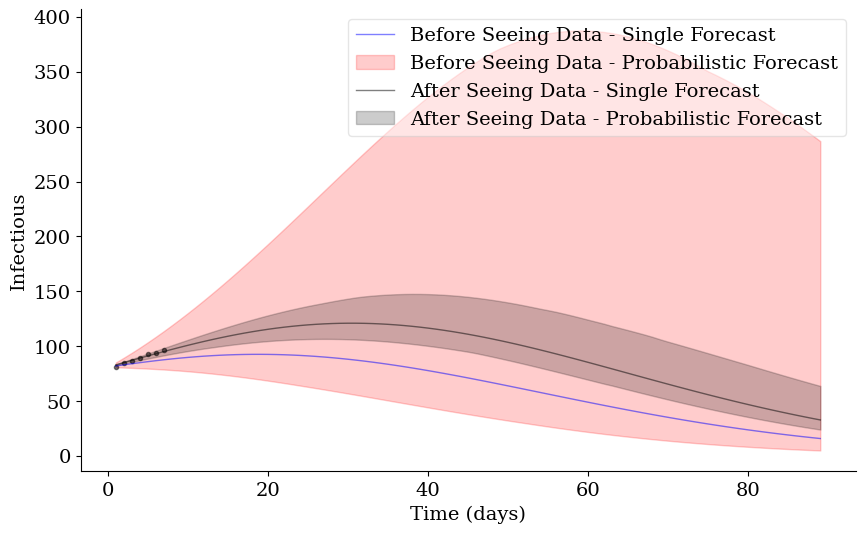

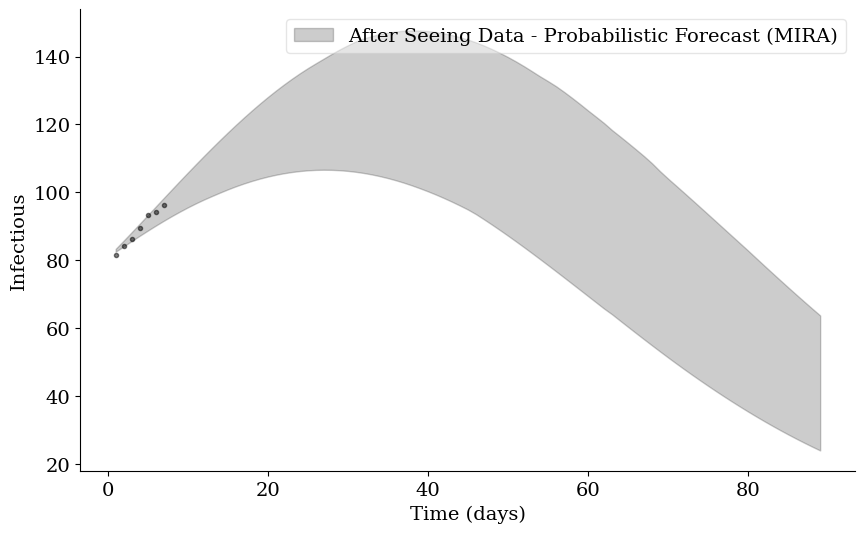

In [166]:
ax = plot_trajectory(plot_I_obs, get_tspan(1, len(I_obs), len(I_obs)), ax=setup_ax())
ax = plot_trajectory(single_prior, full_tspan, ax=ax, color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax = plot_trajectory(single_posterior, full_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, full_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast")
ax = plot_trajectory(plot_I_obs, get_tspan(1,len(I_obs), len(I_obs)), ax=setup_ax())
ax = plot_predictive(posterior_prediction, full_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast (MIRA)")

# Probabilistic forecasting - exploring possible interventions



## Q: "What would happen if we set the vaccination rate parameter, $\nu$, to 0.01 after 7.5 days?"


In [11]:
# note that we cannot intervene at a previously existing timepoint, or odeint will complain.
rate_parameter_intervention = [(7.5, "nu", 0.01)]
num_samples = 100
intervened_parameter_model = intervene(initialized_petri_net_ode_model, rate_parameter_intervention)
intervened_parameter_prediction = sample(intervened_parameter_model, full_tspan, num_samples, calibrated_parameters)
intervened_parameter_prediction['I_obs'] = intervened_parameter_prediction['I_sol'] + intervened_parameter_prediction['I_v_sol']

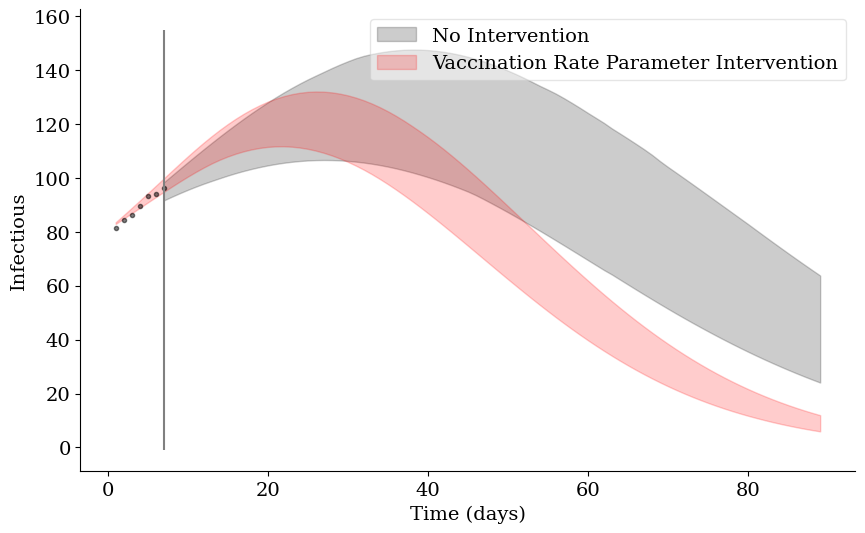

In [167]:
ax = setup_ax()
ax = plot_trajectory(plot_I_obs, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, full_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, full_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)

# Risk-based optimization under uncertainty
## Q: "What is the minimal vaccination policy that results in less than 10 infected individuals after 90 days?"

### Problem Formulation
* **Quantity of interest**: 7-day average of total infections after 90 days
    $$M(\mathbf{u}, \theta) = \frac{1}{7}\sum_{i=0}^6 I(t=90-i;\mathbf{u},\theta)+I_\text{V}(t=90-i;\mathbf{u},\theta)$$

* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Vaccination rate parameter: $u=\nu$



* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the vaccination rate.
    * Constraint - Risk of infections exceeding the prescribed threshold of 10, $\mathcal{R}( M(\mathbf{u}, \theta))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

## Comparing risk measures

![table_risk.png](figures/table_risk.png)

#### Adavantages of using alpha-superquantile
* Considers magnitude of infections exceeding the threshold:
    * Overcome limitations of hard thresholding
    * Desirable data-informed conservativeness
* Preserves properties of underlying quantities of interest, such as convexity

### Exploring the intervention on $\nu$ to highlight the difference between Quantiles and Superquantiles

In [130]:
control_model = copy.deepcopy(initialized_petri_net_ode_model)
INTERVENTION= {"intervention1": [7.5, "nu"]} # Control action / intervention
QOI = lambda y: scenario2dec_sample_average(y, contexts=["I_obs"])

In [131]:
POLICY = 0.01
N_SAMPLES = 100
RISK = computeRisk(model=control_model,
                   interventions=INTERVENTION,
                   qoi=QOI,
                   risk_measure=alpha_superquantile,
                   num_samples=N_SAMPLES,
                   tspan=full_tspan,
                   guide=calibrated_parameters)

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
# Estimate QoI
sq_qoi = RISK.qoi(sq_dataCube)
# Estimate superquantile risk
sq_sv = RISK.risk_measure(sq_qoi)
# Estimate quantile risk
RISK.risk_measure = alpha_quantile
q_sv = RISK.risk_measure(sq_qoi)
print('quantile: ', q_sv, '\nalpha-superquantile: ', sq_sv)

Forward UQ took 135.39 seconds total (1.35e+00 seconds per model evaluation).
quantile:  78.75498466491699 
alpha-superquantile:  81.32076416015624


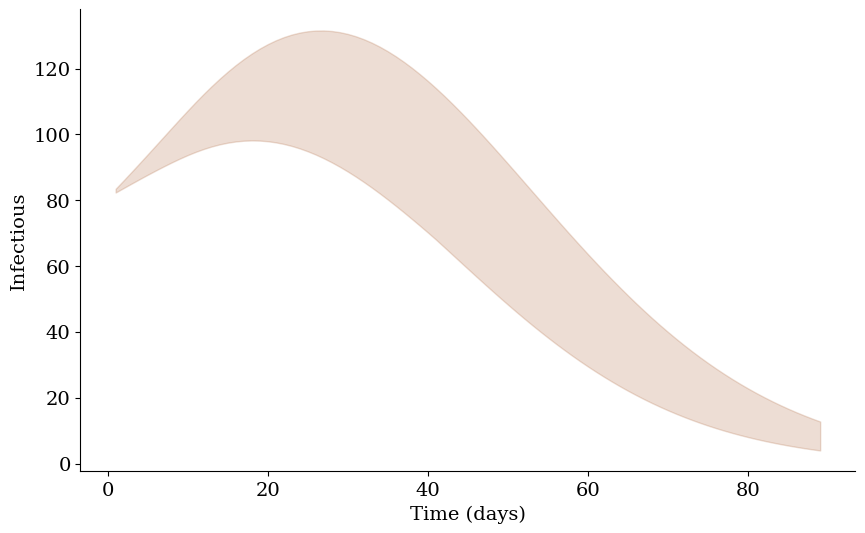

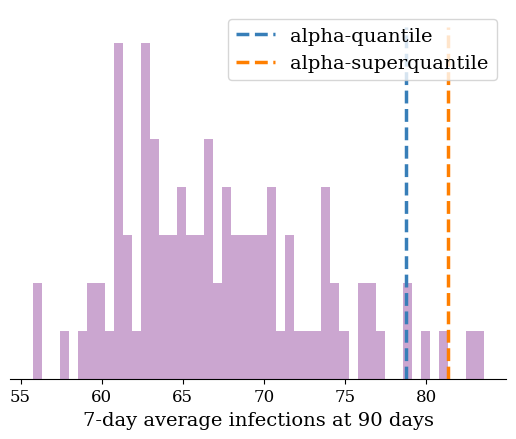

In [168]:
risk_results = {"risk": [q_sv, sq_sv], "samples": sq_dataCube, "qoi": sq_qoi, "tspan": RISK.tspan}
ax1 = plot_ouu_risk(risk_results, color=['#377eb8', '#ff7f00'], label=['alpha-quantile','alpha-superquantile'])

### Setup and run OUU problem
**NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk.

In [128]:
INTERVENTION= {"intervention1": [7.5, "nu"]}
QOI = lambda y: scenario2dec_sample_average(y, contexts=["I_obs"])
timepoints_qoi = range(83,90)
ouu_policy = optimize(initialized_petri_net_ode_model,
                   timepoints=timepoints_qoi,
                   interventions=INTERVENTION,
                   qoi=QOI,
                   risk_bound=10.,
                   initial_guess=0.025,
                   bounds=[[0.],[3.]],
                   n_samples_ouu=int(1e2),
                   maxiter=2,
                   maxfeval=25,
                   inferred_parameters=calibrated_parameters)

Time taken: (5.22e+00 seconds per model evaluation)...
Performing risk-based optimization under uncertainty (using alpha-superquantile)...
Estimated wait time 39136.4 seconds...
Optimization completed in time 4036.79 seconds. Optimal solution:	[0.01145852]
Post-processing optimal policy...
Estimated risk at optimal policy 10.493878173828124


## Assess the effect of the optimal control policy under uncertainty
### Optimum value for $\nu^*=0.0115$

Text(0.5, 1.0, 'Optimal $\\nu$ parameter intervention\nwith risk-based OUU')

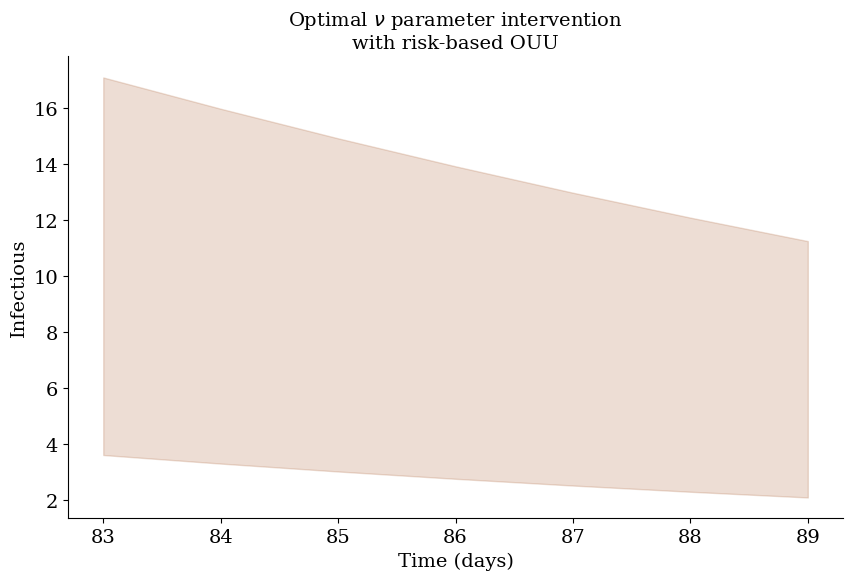

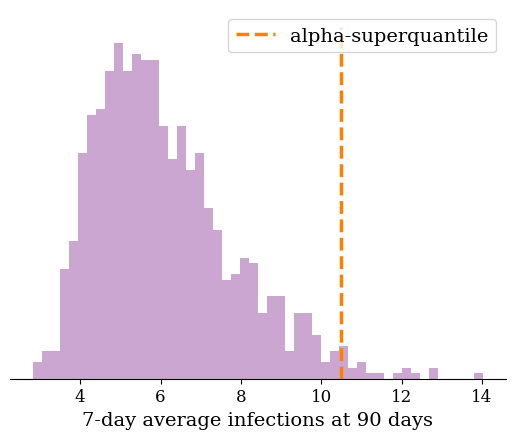

In [169]:
ouu_policy["risk"] = [ouu_policy["risk"]]
ax = plot_ouu_risk(ouu_policy, color=['#ff7f00'])
ax[0].set_title(r"Optimal $\nu$ parameter intervention"+ "\n" + r"with risk-based OUU", size=14)